In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from model import LSTMClassifier
from tqdm import tqdm
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, classification_report




In [2]:
class SeizureDataset(Dataset):
    def __init__(self, data_path, label_path):
        self.data = pd.read_csv(data_path, header=None).values.astype(np.float32)
        self.labels = pd.read_csv(label_path, header=None).values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Use all 1280 features, reshape to [seq_len, 1]
        features = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return features, label

In [3]:
# Define paths
data_path = '/Users/yunhaoluo/Desktop/EEG_analysis/processed_data/'
train_features_path = data_path + "train.csv"
train_labels_path = data_path + "train_labels.csv"
test_features_path = data_path + "test.csv"
test_labels_path = data_path + "test_labels.csv"


In [4]:
# Initialize datasets
train_dataset = SeizureDataset(train_features_path, train_labels_path)
test_dataset = SeizureDataset(test_features_path, test_labels_path)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Model setup
model = LSTMClassifier(1, 128, 3, 1, 0.25)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training parameters
epochs = 150
best_acc = 0
train_losses = []


# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Store training loss
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')
    

Epoch [1/150], Loss: 0.7304
Epoch [2/150], Loss: 0.7074
Epoch [3/150], Loss: 0.7140
Epoch [4/150], Loss: 0.7028
Epoch [5/150], Loss: 0.6940
Epoch [6/150], Loss: 0.6926
Epoch [7/150], Loss: 0.6830
Epoch [8/150], Loss: 0.7112
Epoch [9/150], Loss: 0.7076
Epoch [10/150], Loss: 0.6952
Epoch [11/150], Loss: 0.7018
Epoch [12/150], Loss: 0.6900
Epoch [13/150], Loss: 0.7053
Epoch [14/150], Loss: 0.6868
Epoch [15/150], Loss: 0.7184
Epoch [16/150], Loss: 0.6974
Epoch [17/150], Loss: 0.6868
Epoch [18/150], Loss: 0.6882
Epoch [19/150], Loss: 0.7004
Epoch [20/150], Loss: 0.6986
Epoch [21/150], Loss: 0.6795
Epoch [22/150], Loss: 0.7199
Epoch [23/150], Loss: 0.6891
Epoch [24/150], Loss: 0.6896
Epoch [25/150], Loss: 0.6902
Epoch [26/150], Loss: 0.6920
Epoch [27/150], Loss: 0.6751
Epoch [28/150], Loss: 0.7221
Epoch [29/150], Loss: 0.7025
Epoch [30/150], Loss: 0.6608
Epoch [31/150], Loss: 0.7042
Epoch [32/150], Loss: 0.6709
Epoch [33/150], Loss: 0.7008
Epoch [34/150], Loss: 0.6881
Epoch [35/150], Loss: 0

In [8]:
# Testing and Visualization
def evaluate_and_visualize(model, test_loader):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # 1. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Seizure', 'Seizure'],
                yticklabels=['Non-Seizure', 'Seizure'])
    plt.title('Confusion Matrix')
    plt.show()

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # 3. Sample Visualization
    sample_idx = np.random.randint(0, len(test_dataset))
    sample_data, sample_label = test_dataset[sample_idx]
    with torch.no_grad():
        sample_prob = torch.sigmoid(model(sample_data.unsqueeze(0).to(device))).item()

    plt.figure(figsize=(10, 4))
    plt.plot(sample_data.numpy())
    plt.title(f'Sample Prediction\nTrue: {int(sample_label.item())} ({sample_label.item():.2f}), Pred: {sample_prob:.2f}')
    plt.xlabel('Feature Index (0-1279)')
    plt.ylabel('Value')
    plt.show()

    # 4. Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-Seizure', 'Seizure']))



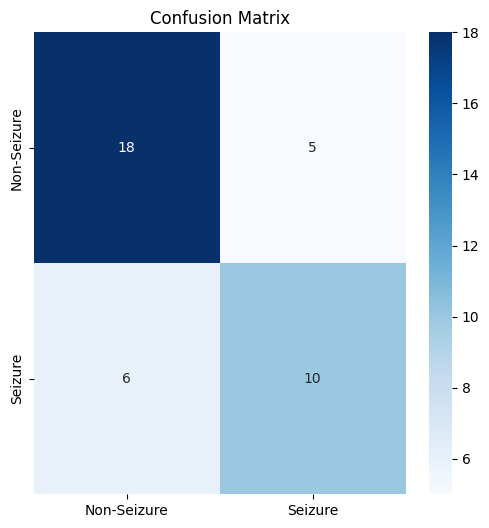

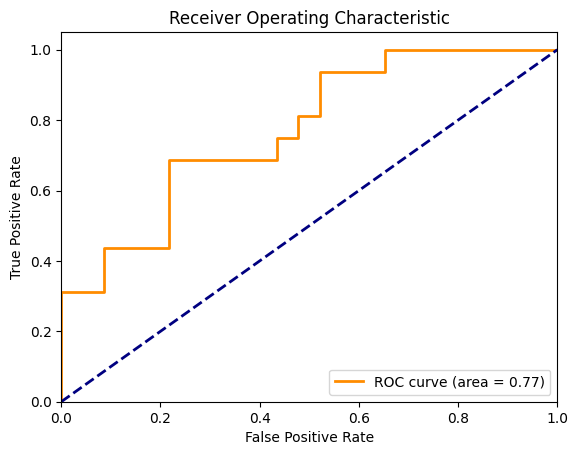

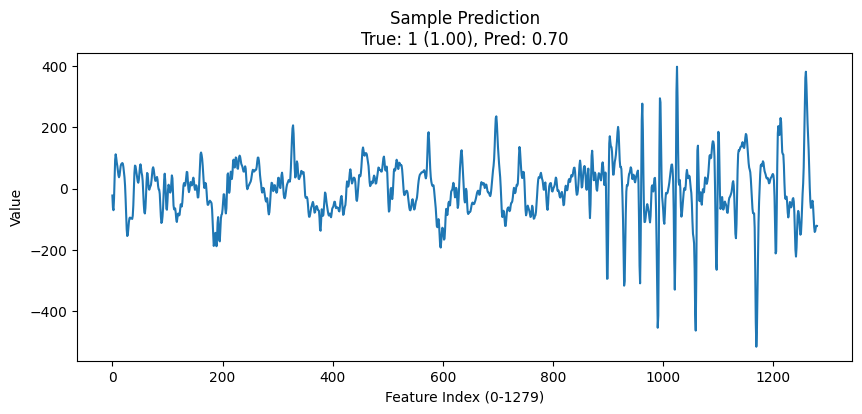


Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.75      0.78      0.77        23
     Seizure       0.67      0.62      0.65        16

    accuracy                           0.72        39
   macro avg       0.71      0.70      0.71        39
weighted avg       0.72      0.72      0.72        39



In [9]:
# Run evaluation
evaluate_and_visualize(model, test_loader)



In [ ]:
# Save final model
torch.save(model.state_dict(), 'seizure_lstm_final.pth')